In [ ]:
# PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree as KDTree
from sklearn.preprocessing import StandardScaler
import re

# INSTALL FUNCTIONS
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from synthetic_data_generator_package.functions.synthetic_data_generator_functions import original_synth_generator, basic_synth_generator, resampling_synth_generator
from synthetic_data_generator_package.functions.kldivergence_function import KLdivergence
print('Current Working Directory:', os.getcwd())

# SET DEFAULTS
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # axes title
plt.rc('axes', labelsize=14)    # x and y labels
plt.rc('xtick', labelsize=14)    # xtick labels
plt.rc('ytick', labelsize=14)    # ytick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('legend', title_fontsize=14)    # legend title
#plt.rc('figure', titlesize=23)  # figure title
#rcParams.update(matplotlib.rcParamsDefault) # reset to DEFAULT

seed = np.random.randint(0,1000)
output_dir = _

Current Working Directory: c:\Users\si327\OneDrive - University of Exeter\Documents\DDRC\Synthetic Data\GitHub_Repo\synthetic-data-generator\notebooks


In [ ]:
# LOAD SAVED DATA
thromb_values_filepath = r"C:\Users\si327\OneDrive - University of Exeter\Documents\DDRC\Synthetic Data\GitHub_Repo\synthetic-data-generator\synthetic_data_generator_package\datasets\thromb_values_for_plots.npz"
thromb_data = np.load(thromb_values_filepath)
large_v_sample1_kl = thromb_data['large_v_sample1_kl']
sample2_v_sample1 = thromb_data['sample2_v_sample1']
fsm_sample1_v_synth_kl = thromb_data['fsm_sample1_v_synth_kl']
fsm_large_v_synth_kl = thromb_data['fsm_large_v_synth_kl']
fsm_sample2_v_synth_kl = thromb_data['fsm_sample2_v_synth_kl']
fsm_ta_sample1_v_synth_kl = thromb_data['fsm_ta_sample1_v_synth_kl']
fsm_ta_large_v_synth_kl = thromb_data['fsm_ta_large_v_synth_kl']
fsm_ta_sample2_v_synth_kl = thromb_data['fsm_ta_sample2_v_synth_kl']
resamp_sample1_v_synth_kl = thromb_data['resamp_sample1_v_synth_kl']
resamp_large_v_synth_kl = thromb_data['resamp_large_v_synth_kl']
resamp_sample2_v_synth_kl = thromb_data['resamp_sample2_v_synth_kl']


values_filepath = r"C:\Users\si327\OneDrive - University of Exeter\Documents\DDRC\Synthetic Data\GitHub_Repo\synthetic-data-generator\synthetic_data_generator_package\datasets\values_for_plots.npz"
saved_data = np.load(values_filepath)
sigma_data = saved_data['sigma_data']
dimension_data = saved_data['dimension_data']
ds_size_data = saved_data['ds_size_data']

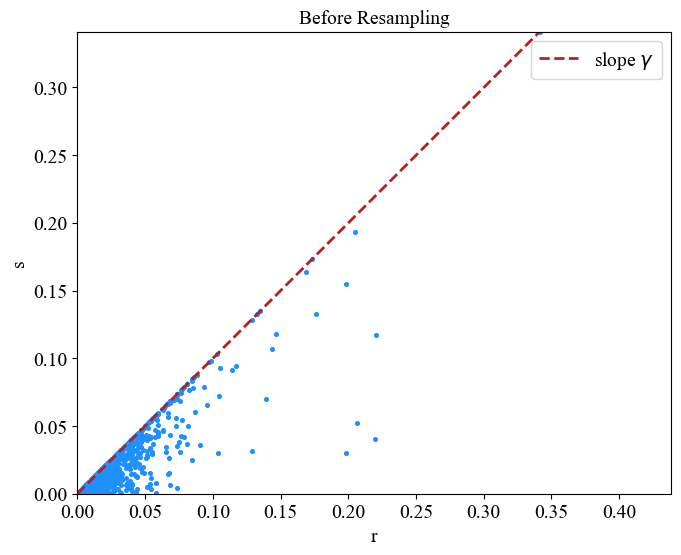

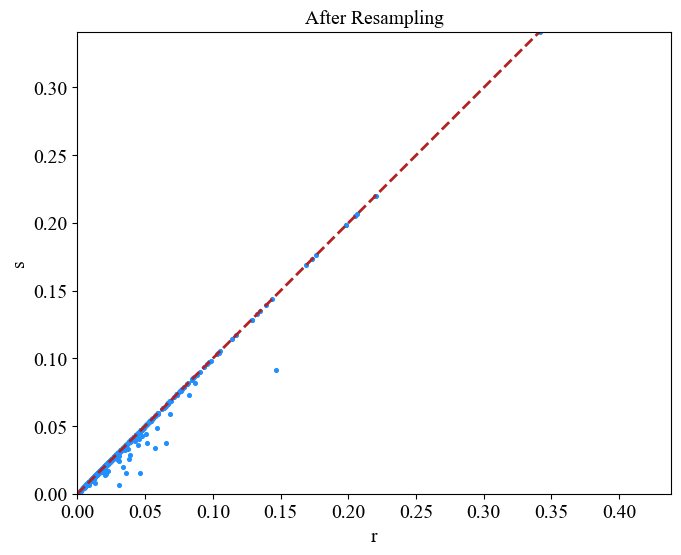

In [6]:
# PLOT BEFORE AND AFTER RESAMPLING S-R PLOTS
from scipy.spatial import cKDTree as KDTree


def slope_gamma(no_samples=1000, features=2, seed=733):
    f, t = make_classification( n_samples=no_samples*2, n_features=features, 
                                n_informative=features, n_redundant=0,
                                n_clusters_per_class=1, flip_y=0, class_sep=1,
                                random_state=seed)
    f = f[t==0]

    sigma=0
    _, basic_f = original_synth_generator(f, f.shape[0], sigma=sigma, sequential=True)
    _, resamp_f = resampling_synth_generator(f, f.shape[0], sigma=sigma, resamples=50, repeats=50, sequential=True)

    # Create KDTrees
    orig_tree = KDTree(f)
    basic_tree = KDTree(basic_f)
    resamp_tree = KDTree(resamp_f)

    r_orig = orig_tree.query(f, k=2, p=2)[0][:,1] # distances to nearest neighbour between sample one and sample one (against itself)

    s_basic = basic_tree.query(f, k=2, p=2)[0] # distances to nearest neighbour between sample one and basic synthetic dataset (against parent dataset)
    s_basic = np.where(s_basic[:,0] == 0.0, s_basic[:,1], s_basic[:,0])

    s_resamp = resamp_tree.query(f, k=2, p=2)[0] # distances to nearest neighbour between sample one and resamp synthetic dataset (against parent dataset)
    s_resamp = np.where(s_resamp[:,0] == 0.0, s_resamp[:,1], s_resamp[:,0])

    xmax = np.max(r_orig)
    ymax = np.max(np.stack([s_basic, s_resamp]))
    xmax = ymax*(9/7)

    gamma=((f.shape[0]-1)/basic_f.shape[0])**(1/2)
    plt.figure(figsize=(8,6))
    plt.axline((0, 0), linestyle='--', slope=gamma, c='firebrick', label='slope $\gamma$', linewidth=2)
    plt.scatter(r_orig, s_basic, s=7, c='dodgerblue')
    plt.axis('scaled')
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)
    plt.legend()
    plt.xlabel('r')
    plt.ylabel('s')
    plt.title('Before Resampling')
    full_filepath = os.path.join(output_dir, 'before_resamp.pdf')
    plt.savefig(full_filepath, format='pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(8,6))
    plt.axline((0, 0), linestyle='--', slope=gamma, c='firebrick', linewidth=2)
    plt.scatter(r_orig, s_resamp, s=7, c='dodgerblue')
    plt.axis('scaled')
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)
    plt.xlabel('r')
    plt.ylabel('s')
    plt.title('After Resampling')
    full_filepath = os.path.join(output_dir, 'after_resamp.pdf')
    plt.savefig(full_filepath, format='pdf', bbox_inches='tight')
    plt.show()

slope_gamma()    

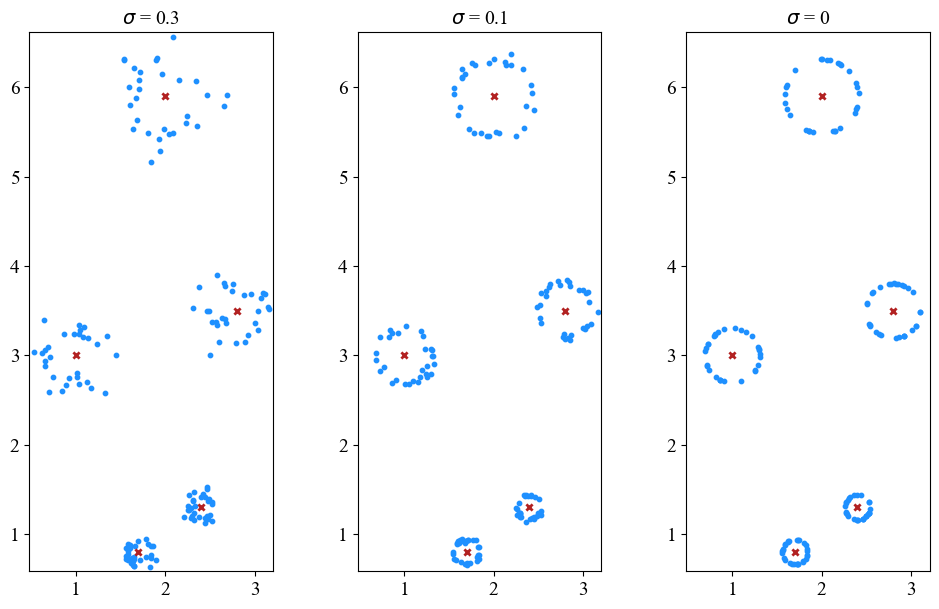

In [8]:
def vary_sigma(save=False, seeded=True):
    sigma_range = [0.3, 0.1, 0]

    if seeded:
        orig_points = np.array([[1.7, 0.8],
                                [2.4, 1.3],
                                [1, 3],
                                [2.8, 3.5],
                                [2, 5.9]])
    else:
        orig_points = np.random.rand(*(5,2))
        orig_points[:,0] = np.abs(orig_points[:,0])*2 # force the points to look vertical
        orig_points[:,1] = np.abs(orig_points[:,1])*3 # force the points to look vertical


    # make synthetic points
    grouped_synth_points=[]
    for sigma in sigma_range:
        grouped_synth_points.append((original_synth_generator(orig_points, orig_points.shape[0]*30, sigma=sigma))[1])
        
    xmin, xmax = np.min(grouped_synth_points[0][:,0]), np.max(grouped_synth_points[0][:,0])  # Set the desired range for x-axis
    ymin, ymax = np.min(grouped_synth_points[0][:,1]), np.max(grouped_synth_points[0][:,1])  # Set the desired range for y-axis

    if save:
        for i, synth_points in enumerate(grouped_synth_points):
            plt.figure(figsize=(6,10))
            plt.scatter(grouped_synth_points[0][:,0], grouped_synth_points[0][:,1], s=30, c='white')
            plt.scatter(grouped_synth_points[1][:,0], grouped_synth_points[1][:,1], s=30, c='white')
            plt.scatter(synth_points[:,0], synth_points[:,1], s=30, c='dodgerblue')
            plt.scatter(orig_points[:,0], orig_points[:,1], marker='x', s=80, linewidths=4, c='firebrick')
            plt.axis('scaled')
            plt.xlim(xmin-0.05, xmax+0.05)
            plt.ylim(ymin-0.05, ymax+0.05)
            plt.xticks([])
            plt.yticks([])
            full_filepath=os.path.join(output_dir, 'sigma' + str(sigma_range[i]) + '.pdf')
            plt.savefig(full_filepath, format='pdf', bbox_inches='tight')

    _, axs = plt.subplots(1,3, figsize=(12,7))
    for i, synth_points in enumerate(grouped_synth_points):
        axs[i].scatter(grouped_synth_points[0][:,0], grouped_synth_points[0][:,1], s=10, c='white')
        axs[i].scatter(grouped_synth_points[1][:,0], grouped_synth_points[1][:,1], s=10, c='white')
        axs[i].scatter(synth_points[:,0], synth_points[:,1], s=10, c='dodgerblue')
        axs[i].scatter(orig_points[:,0], orig_points[:,1], marker='x', s=20, linewidths=2, c='firebrick')
        axs[i].axis('scaled')
        axs[i].set_xlim(xmin-0.05, xmax+0.05)
        axs[i].set_ylim(ymin-0.05, ymax+0.05)
        axs[i].set_title('$\sigma$ = ' + str(sigma_range[i]))
        #axs[i].set_axis_off()
    plt.show()
    
vary_sigma()

In [13]:
# PREPROCESS STROKE DATA
train_stroke_data = pd.read_csv(r"C:\Users\si327\OneDrive - University of Exeter\Documents\DDRC\Synthetic Data\Thrombolysis\data_for_synthetic.csv")
train_stroke_data = train_stroke_data.drop('Index', axis = 1) # remove index column

train_stroke_data = train_stroke_data.dropna()
train_stroke_data = train_stroke_data.drop_duplicates()

train_stroke_data = train_stroke_data.rename(columns={'Team_':'Team'}) # rename team column

# Extract numerical values from categorical 'Team' column
import re
ints = []
for i in range(len(train_stroke_data)):
    string = train_stroke_data['Team'].iloc[i]
    string = re.findall(r'\d+', string) # find team number and extract it
    ints.append(int(string[0])) # turn into integer
train_stroke_data['Team'] = ints
ints = []

# Isolate features from target columns
stroke_f = np.array(train_stroke_data.drop('Target', axis = 1)) # isolate feature columns

In [18]:
# Make synthetic data from stroke 10-d data
from sklearn.preprocessing import StandardScaler

def process_thromb_data(stroke_f, sigma=0):
    large_v_sample1_kl = []
    sample2_v_sample1 = []
    fsm_sample1_v_synth_kl = []
    fsm_large_v_synth_kl = []
    fsm_sample2_v_synth_kl = []
    resamp_sample1_v_synth_kl = []
    resamp_large_v_synth_kl = []
    resamp_sample2_v_synth_kl = []

    _, f = train_test_split(stroke_f, test_size=10000) # get a sample of 10000 from f
    for run in range(100):
        scaler=StandardScaler()
        scaled_f = scaler.fit_transform(f)

        sample_size = 500
        rest, f_sample1 = train_test_split(scaled_f, test_size=sample_size)
        _, f_sample2 = train_test_split(rest, test_size=sample_size)

        # Create Synthetic Data
        resamp_samples = 50
        resamp_repeats = 50
        _, fsm = original_synth_generator(f_sample1, f_sample1.shape[0], sigma=sigma, sequential=True)
        _, resamp = resampling_synth_generator(f_sample1, f_sample1.shape[0], sigma=sigma, repeats=resamp_repeats, resamples=resamp_samples, sequential=True)

        large_v_sample1_kl.append(KLdivergence(scaled_f, f_sample1))
        sample2_v_sample1.append(KLdivergence(f_sample2,f_sample1))

        fsm_sample1_v_synth_kl.append(KLdivergence(f_sample1, fsm))
        fsm_large_v_synth_kl.append(KLdivergence(scaled_f, fsm))
        fsm_sample2_v_synth_kl.append(KLdivergence(f_sample2, fsm))

        resamp_sample1_v_synth_kl.append(KLdivergence(f_sample1, resamp))
        resamp_large_v_synth_kl.append(KLdivergence(scaled_f, resamp))
        resamp_sample2_v_synth_kl.append(KLdivergence(f_sample2, resamp))

    return (large_v_sample1_kl,
            sample2_v_sample1,

            fsm_sample1_v_synth_kl,
            fsm_large_v_synth_kl,
            fsm_sample2_v_synth_kl,

            resamp_sample1_v_synth_kl,
            resamp_large_v_synth_kl,
            resamp_sample2_v_synth_kl)

(large_v_sample1_kl,
sample2_v_sample1,

fsm_sample1_v_synth_kl,
fsm_large_v_synth_kl,
fsm_sample2_v_synth_kl,

resamp_sample1_v_synth_kl,
resamp_large_v_synth_kl,
resamp_sample2_v_synth_kl) = process_thromb_data(stroke_f, 0.02)

In [20]:
# VIOLIN PLOT FUNCTION

import seaborn as sns
import matplotlib.colors as mcolors

colour_hex = mcolors.CSS4_COLORS

def make_violin_plot(data, column_names):
    data = pd.DataFrame(data.T, columns=column_names)

    plt.figure(figsize=(8,6))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'legend.title_fontsize': 16,
        'figure.titlesize': 16
    })

    custom_palette = [colour_hex['firebrick'], colour_hex['orange'], colour_hex['mediumseagreen'], colour_hex['dodgerblue'], colour_hex['slateblue']]

    sns.violinplot(data, inner='quartiles', orient='v', density_norm='count', palette=custom_palette)
    plt.xticks(rotation=25)
    plt.axhline(0, linestyle = '--', color='gray')
    plt.ylabel('KL Divergence')
    #params = "[dimensions = " + str(f.shape[1]) + "] [large original size = " + str(f.shape[0]) + '] [original samp size = ' + str(f_sample1.shape[0]) + "] [synthetic samp size = " + str(fsm.shape[0]) + "] [sigma = " + str(sigma) + "] [everypoint = True]"
    #plt.text(-2, -5, params, c='gray')
    plt.tight_layout()

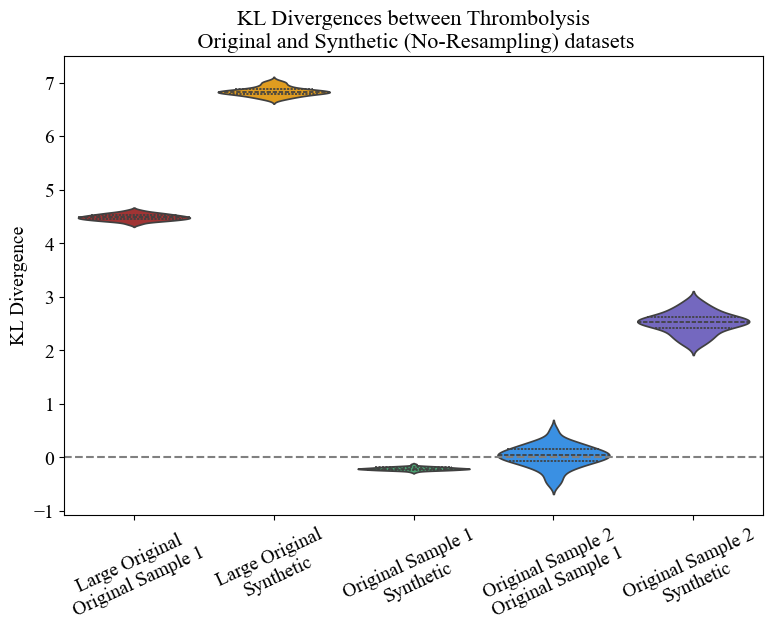

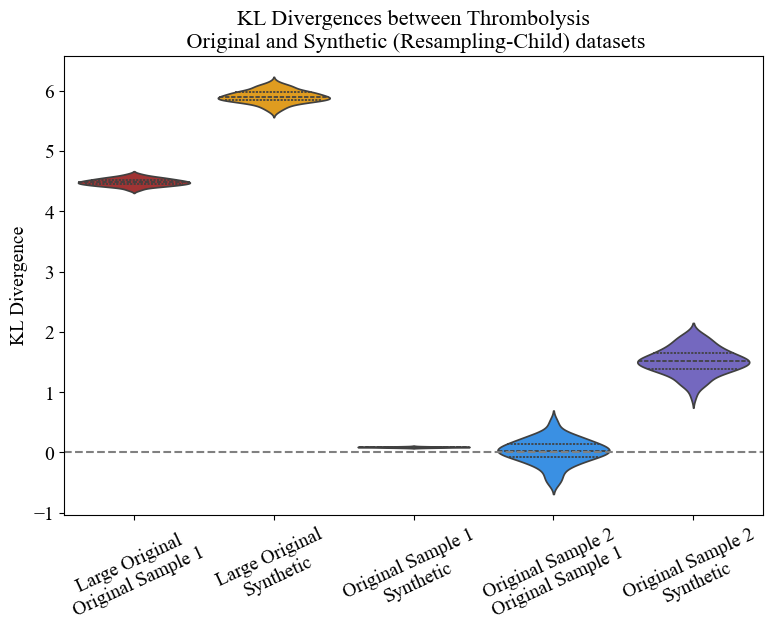

In [21]:
# MAKE VIOLINS PLOTS - STROKE 10-D

data = np.asarray([large_v_sample1_kl, fsm_large_v_synth_kl, fsm_sample1_v_synth_kl, sample2_v_sample1, fsm_sample2_v_synth_kl])
columns = ["Large Original\nOriginal Sample 1", "Large Original\nSynthetic", "Original Sample 1\nSynthetic", "Original Sample 2\nOriginal Sample 1", "Original Sample 2\nSynthetic"]
make_violin_plot(data, columns)
plt.title('KL Divergences between Thrombolysis\n Original and Synthetic (No-Resampling) datasets')
filename = "stroke_no_resamp_violin_plot.pdf"
full_filepath = os.path.join(output_dir, filename)
plt.savefig(full_filepath, format='pdf', bbox_inches='tight')
plt.show()

data = np.asarray([large_v_sample1_kl, resamp_large_v_synth_kl, resamp_sample1_v_synth_kl, sample2_v_sample1, resamp_sample2_v_synth_kl])
columns = ["Large Original\nOriginal Sample 1", "Large Original\nSynthetic", "Original Sample 1\nSynthetic", "Original Sample 2\nOriginal Sample 1", "Original Sample 2\nSynthetic"]
make_violin_plot(data, columns)
plt.title('KL Divergences between Thrombolysis\n Original and Synthetic (Resampling-Child) datasets')
filename = "stroke_resamp_chd_violin_plot.pdf"
full_filepath = os.path.join(output_dir, filename)
plt.savefig(full_filepath, format='pdf', bbox_inches='tight')
plt.show()

In [22]:
def get_data(sigma_range=None, dimension_range=None, ds_size_range=None, everypoint=True, std_on=False):
    if sum(x is None for x in (sigma_range, dimension_range, ds_size_range)) != 2:
        print(sum(x is None for x in (sigma_range, dimension_range, ds_size_range)))
        raise ValueError('Error: Only one variable can be changed at once.')
    
    sample1_v_sample2_mean_kl = []
    large_v_sample2_mean_kl = []
    fsm_sample1_v_synth_mean_kl = []
    fsm_large_v_synth_mean_kl = []
    resamp_sample1_v_synth_mean_kl = []
    resamp_large_v_synth_mean_kl = []

    sample1_v_sample2_std_kl = []
    large_v_sample2_std_kl = []
    fsm_sample1_v_synth_std_kl = []
    fsm_large_v_synth_std_kl = []
    resamp_sample1_v_synth_std_kl = []
    resamp_large_v_synth_std_kl = []

    # set defaults
    resamp_samples = 50
    resamp_repeats = 50

    if sigma_range != None:
        var_range = sigma_range
    if dimension_range != None:
        var_range = dimension_range
    if ds_size_range != None:
        var_range = ds_size_range

    for var in var_range:
        if sigma_range != None:
            sigma = var
            features = 10
            test_size = 500
        if dimension_range != None:
            features = var
            sigma = 0.02
            test_size = 500
        if ds_size_range != None:
            test_size = var
            sigma = 0.02
            features = 10

        sample1_v_sample2_kl = []
        large_v_sample2_kl = []
        fsm_sample1_v_synth_kl = []
        fsm_large_v_synth_kl = []
        resamp_sample1_v_synth_kl = []
        resamp_large_v_synth_kl = []
        for _ in range(7):
            no_samples = 10000
            features = features
            # Create a random binary classification dataset
            f, _ = make_classification( n_samples=no_samples, n_features=features, 
                                        n_informative=features, n_redundant=0,
                                        n_clusters_per_class=1, flip_y=0, class_sep=1,
                                        )
            for _ in range(5):
                rest, f_sample1 = train_test_split(f, test_size=test_size)
                _, f_sample2 = train_test_split(rest, test_size=test_size)
                
                _, fsm = fancy_smote_cov(f_sample1, f_sample1.shape[0], sigma=sigma, everypoint=everypoint)
                _, resamp = resampling_smote(f_sample1, f_sample1.shape[0], sigma=sigma, repeats=resamp_repeats, resamples=resamp_samples, everypoint=everypoint)

                sample1_v_sample2_kl.append(KLdivergence(f_sample1, f_sample2))
                large_v_sample2_kl.append(KLdivergence(f, f_sample2))

                fsm_sample1_v_synth_kl.append(KLdivergence(f_sample1, fsm))
                fsm_large_v_synth_kl.append(KLdivergence(f, fsm))

                resamp_sample1_v_synth_kl.append(KLdivergence(f_sample1, resamp))
                resamp_large_v_synth_kl.append(KLdivergence(f, resamp))

        sample1_v_sample2_mean_kl.append(np.mean(sample1_v_sample2_kl))
        large_v_sample2_mean_kl.append(np.mean(large_v_sample2_kl))
        fsm_sample1_v_synth_mean_kl.append(np.mean(fsm_sample1_v_synth_kl))
        fsm_large_v_synth_mean_kl.append(np.mean(fsm_large_v_synth_kl))
        resamp_sample1_v_synth_mean_kl.append(np.mean(resamp_sample1_v_synth_kl))
        resamp_large_v_synth_mean_kl.append(np.mean(resamp_large_v_synth_kl))

        sample1_v_sample2_std_kl.append(np.std(sample1_v_sample2_kl))
        large_v_sample2_std_kl.append(np.std(large_v_sample2_kl))
        fsm_sample1_v_synth_std_kl.append(np.std(fsm_sample1_v_synth_kl))
        fsm_large_v_synth_std_kl.append(np.std(fsm_large_v_synth_kl))
        resamp_sample1_v_synth_std_kl.append(np.std(resamp_sample1_v_synth_kl))
        resamp_large_v_synth_std_kl.append(np.std(resamp_large_v_synth_kl))                    
        
    sample1_v_sample2_mean_kl = np.array(sample1_v_sample2_mean_kl)
    large_v_sample2_mean_kl = np.array(large_v_sample2_mean_kl)
    fsm_sample1_v_synth_mean_kl = np.array(fsm_sample1_v_synth_mean_kl)
    fsm_large_v_synth_mean_kl = np.array(fsm_large_v_synth_mean_kl)
    resamp_sample1_v_synth_mean_kl = np.array(resamp_sample1_v_synth_mean_kl)
    resamp_large_v_synth_mean_kl = np.array(resamp_large_v_synth_mean_kl)

    sample1_v_sample2_std_kl = np.array(sample1_v_sample2_std_kl)
    large_v_sample2_std_kl = np.array(large_v_sample2_std_kl)
    fsm_sample1_v_synth_std_kl = np.array(fsm_sample1_v_synth_std_kl)
    fsm_large_v_synth_std_kl = np.array(fsm_large_v_synth_std_kl)
    resamp_sample1_v_synth_std_kl = np.array(resamp_sample1_v_synth_std_kl)
    resamp_large_v_synth_std_kl = np.array(resamp_large_v_synth_std_kl)

    return (sample1_v_sample2_mean_kl,
            fsm_sample1_v_synth_mean_kl,
            resamp_sample1_v_synth_mean_kl,
            large_v_sample2_mean_kl,
            fsm_large_v_synth_mean_kl,
            resamp_large_v_synth_mean_kl,

            sample1_v_sample2_std_kl,
            fsm_sample1_v_synth_std_kl,
            resamp_sample1_v_synth_std_kl,
            large_v_sample2_std_kl,
            fsm_large_v_synth_std_kl,
            resamp_large_v_synth_std_kl)

In [23]:
# PLOT INDIVIDUAL PLOTS

def plot_variable_plots(data, var_range, var_name, std_on=False, save_dir=False):

    plt.figure(figsize=(7,5))
    if not(var_name == '$\sigma$'):
        plt.plot(var_range, data[0], '-o', label="Original Sample 2", c= 'firebrick')
    plt.plot(var_range, data[1], '-o', label="No Resampling", c='orange')
    plt.plot(var_range, data[2], '-o', label="Resampling Child", c='dodgerblue')
    plt.axhline(0, linestyle = '--', color='gray')
    plt.ylabel('Mean KL Divergence')
    plt.xlabel(var_name)
    if not(var_name == '$\sigma$'):
        plt.legend(title='Original Sample 1 VS')
    if var_name == 'Dataset Size':
        plt.legend(loc='upper right')
    else:
        plt.legend()
    if std_on:
        if not(var_name == '$\sigma$'):
            plt.errorbar(var_range, data[0], yerr=data[6], capsize=2, fmt='-o', label="Original Sample 2", c= 'firebrick')
            plt.fill_between(var_range, data[0] - data[6], data[0] + data[6], alpha=0.2, color= 'firebrick')
        plt.errorbar(var_range, data[1], yerr=data[7], capsize=2, fmt='-o', label="No Resampling", c='orange')
        plt.fill_between(var_range, data[1] - data[7], data[1] + data[7], alpha=0.2, color='orange')
        plt.errorbar(var_range, data[2], yerr=data[8], capsize=2, fmt='-o', label="Resampling Child", c='dodgerblue')
        plt.fill_between(var_range, data[2] - data[8], data[2] + data[8], alpha=0.2, color='dodgerblue')
    plt.tight_layout()
    if save_dir:
        if var_name == '$\sigma$':
            var_name = 'sigma'
        filename = 'vary_' + str(var_name) + '_a.pdf'
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath, format='pdf')
    plt.show()

    plt.figure(figsize=(7,5))
    if not(var_name == '$\sigma$'):
        plt.plot(var_range, data[3], '-o', label="Original Sample 2", c= 'firebrick')
    plt.plot(var_range, data[4], '-o', label="No Resampling", c='orange')
    plt.plot(var_range, data[5], '-o', label="Resampling Child", c='dodgerblue')
    plt.axhline(0, linestyle = '--', color='gray')
    plt.ylabel('Mean KL Divergence')
    plt.xlabel(var_name)
    if not(var_name == '$\sigma$'):
        plt.legend(title='Large Original VS')
    else:
        plt.legend()
    if std_on:
        if not(var_name == '$\sigma$'):
            plt.errorbar(var_range, data[3], yerr=data[9], capsize=2, fmt='-o', label="Original Sample 2", c= 'firebrick')
            plt.fill_between(var_range, data[3] - data[9], data[3] + data[9], alpha=0.2, color= 'firebrick')
        plt.errorbar(var_range, data[4], yerr=data[10], capsize=2, fmt='-o', label="No Resampling", c='orange')
        plt.fill_between(var_range, data[4] - data[10], data[4] + data[10], alpha=0.2, color='orange')
        plt.errorbar(var_range, data[5], yerr=data[11], capsize=2, fmt='-o', label="Resampling Child", c='dodgerblue')
        plt.fill_between(var_range, data[5] - data[11], data[5] + data[11], alpha=0.2, color='dodgerblue')
    plt.tight_layout()
    if save_dir:
        if var_name == '$\sigma$':
            var_name = 'sigma'
        filename = 'vary_' + str(var_name) + '_b.pdf'
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath, format='pdf')
    plt.show()

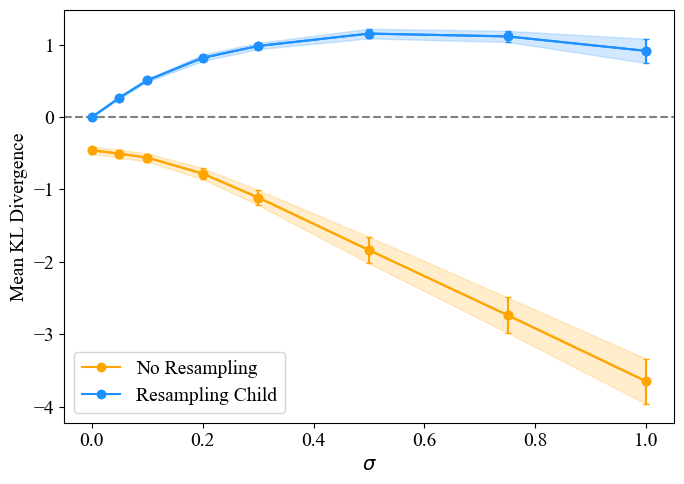

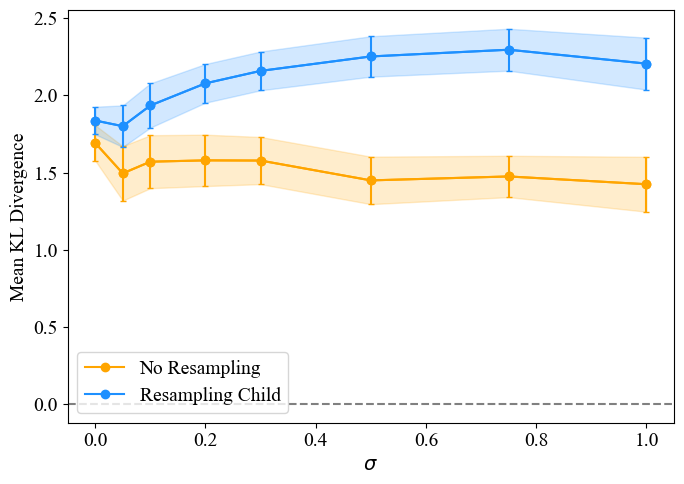

In [24]:
# How does KLD change with varying sigma?

sigma_range = [0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]
std_on = True

#sigma_data  = get_data(sigma_range=sigma_range, std_on=std_on)
plot_variable_plots(sigma_data, sigma_range, '$\sigma$', std_on=True)

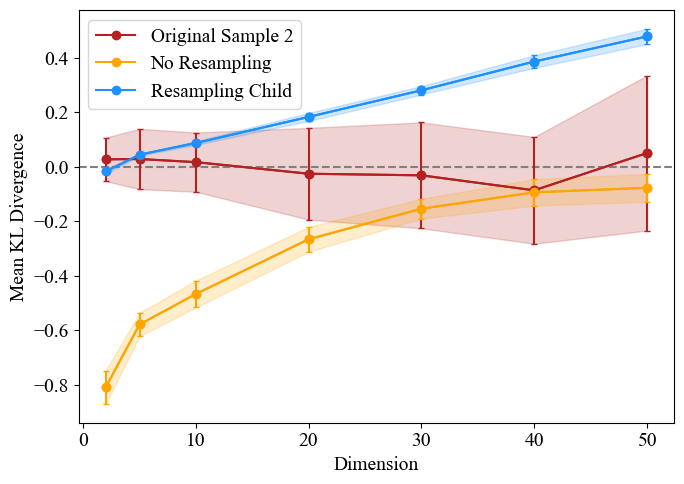

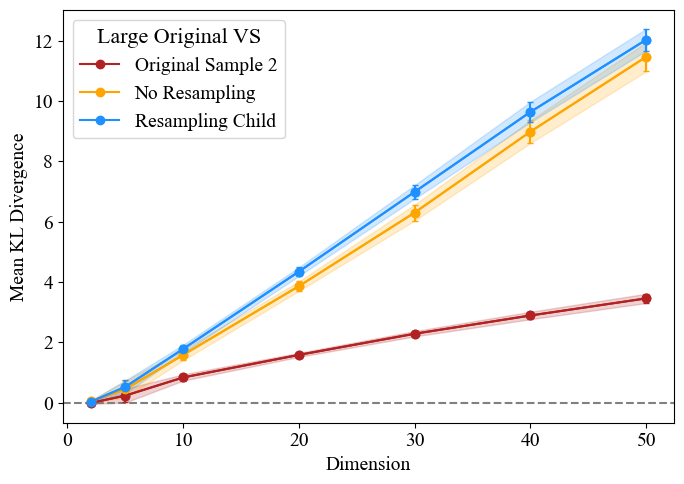

In [25]:
# How does KLD change with varying dimension?

dimension_range = [2,5,10,20,30,40,50]
std_on = True

#dimension_data  = get_data(dimension_range=dimension_range, std_on=std_on)
plot_variable_plots(dimension_data, dimension_range, 'Dimension', std_on=True)

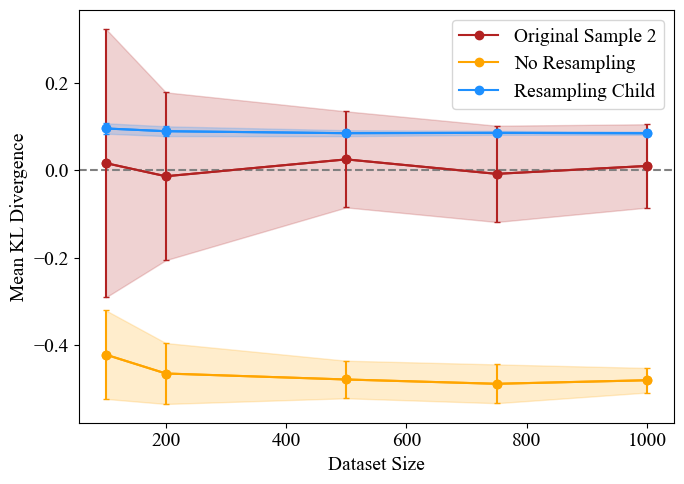

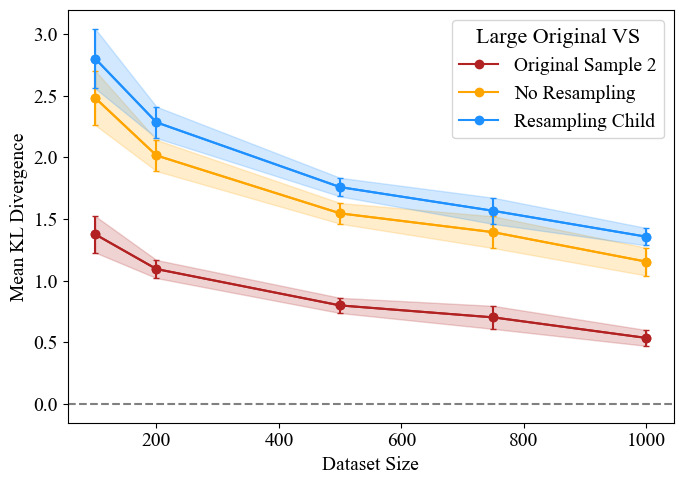

In [26]:
# How does KLD change with varying dataset size?

ds_size_range = [100, 200, 500, 750, 1000]
std_on = True

#ds_size_data  = get_data(ds_size_range=ds_size_range, std_on=std_on)
plot_variable_plots(ds_size_data, ds_size_range, 'Dataset Size', std_on=True)

In [ ]:
# SAVE DATA

np.savez(values_filepath, sigma_data=sigma_data, dimension_data=dimension_data, ds_size_data=ds_size_data)
np.savez(thromb_values_filepath,    large_v_sample1_kl=large_v_sample1_kl,
                                    sample2_v_sample1=sample2_v_sample1,

                                    fsm_sample1_v_synth_kl=fsm_sample1_v_synth_kl,
                                    fsm_large_v_synth_kl=fsm_large_v_synth_kl,
                                    fsm_sample2_v_synth_kl=fsm_sample2_v_synth_kl,

                                    fsm_ta_sample1_v_synth_kl=fsm_ta_sample1_v_synth_kl,
                                    fsm_ta_large_v_synth_kl=fsm_ta_large_v_synth_kl,
                                    fsm_ta_sample2_v_synth_kl=fsm_ta_sample2_v_synth_kl,

                                    resamp_sample1_v_synth_kl=resamp_sample1_v_synth_kl,
                                    resamp_large_v_synth_kl=resamp_large_v_synth_kl,
                                    resamp_sample2_v_synth_kl=resamp_sample2_v_synth_kl)

REAL DIGIT EXAMPLES:


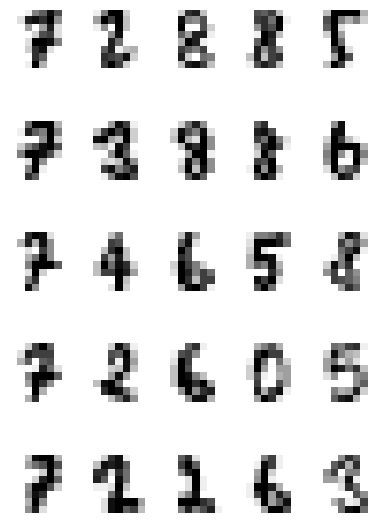

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0     1.0000    0.9886    0.9943        88
           1     0.9888    0.9670    0.9778        91
           2     0.9884    0.9884    0.9884        86
           3     0.9753    0.8681    0.9186        91
           4     0.9888    0.9565    0.9724        92
           5     0.9462    0.9670    0.9565        91
           6     0.9890    0.9890    0.9890        91
           7     0.9565    0.9888    0.9724        89
           8     0.9362    1.0000    0.9670        88
           9     0.9278    0.9783    0.9524        92

    accuracy                         0.9689       899
   macro avg     0.9697    0.9692    0.9689       899
weighted avg     0.9696    0.9689    0.9687       899




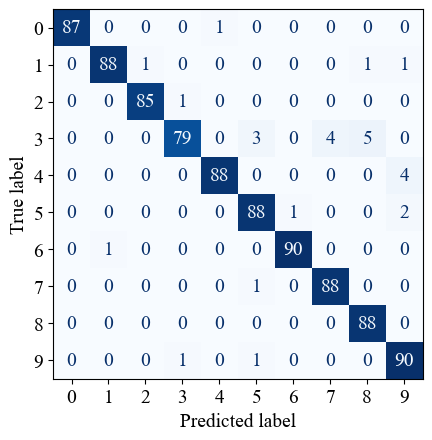

SYNTHETIC DIGITS (NO COVARIANCE) EXAMPLES:


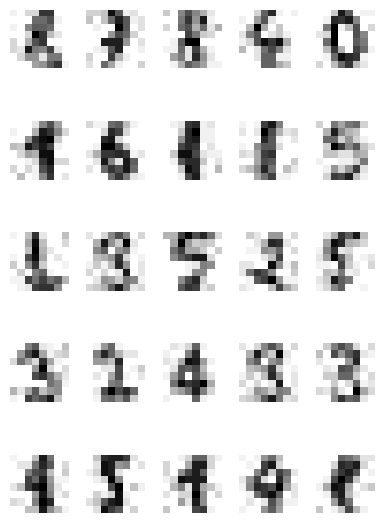

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0     0.9886    0.9886    0.9886        88
           1     0.9775    0.9560    0.9667        91
           2     0.9881    0.9651    0.9765        86
           3     0.9529    0.8901    0.9205        91
           4     0.9889    0.9674    0.9780        92
           5     0.9362    0.9670    0.9514        91
           6     0.9783    0.9890    0.9836        91
           7     0.9570    1.0000    0.9780        89
           8     0.9419    0.9205    0.9310        88
           9     0.8980    0.9565    0.9263        92

    accuracy                         0.9600       899
   macro avg     0.9607    0.9600    0.9601       899
weighted avg     0.9605    0.9600    0.9599       899


SYNTHETIC DIGITS (WITH COVARIANCE) EXAMPLES:


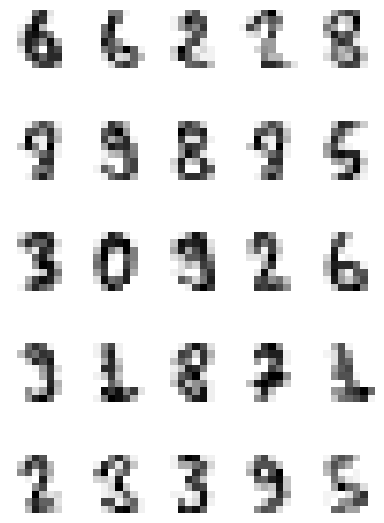

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0     0.9886    0.9886    0.9886        88
           1     0.9278    0.9890    0.9574        91
           2     0.9881    0.9651    0.9765        86
           3     0.9872    0.8462    0.9112        91
           4     0.9884    0.9239    0.9551        92
           5     0.9278    0.9890    0.9574        91
           6     0.9891    1.0000    0.9945        91
           7     0.9362    0.9888    0.9617        89
           8     0.9195    0.9091    0.9143        88
           9     0.9062    0.9457    0.9255        92

    accuracy                         0.9544       899
   macro avg     0.9559    0.9545    0.9542       899
weighted avg     0.9558    0.9544    0.9541       899




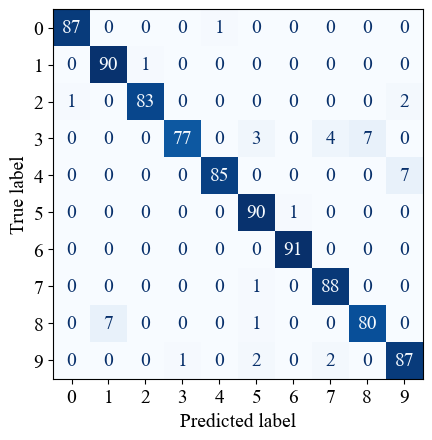

In [33]:
from sklearn import datasets, metrics, svm
import random

def run_handwritten_digits(save=False):
    digits = datasets.load_digits()

    # SPLIT INTO TRAIN AND TEST DATASETS
    data = digits['data']

    X_real_train, X_test, y_train, y_test = train_test_split(
        data, digits['target'], test_size=0.5, shuffle=False
    )

    # PLOT REAL DIGITS EXAMPLES
    print('REAL DIGIT EXAMPLES:')
    _, axs = plt.subplots(5, 5, figsize=(4,6))
    axs = axs.ravel()

    for i in range(25):
        image = random.choice(X_real_train)
        image = image.reshape(8,8)
        axs[i].imshow(image, cmap='gray_r')
        axs[i].axis('off')
    plt.tight_layout()
    if save:
        full_filepath = os.path.join(output_dir, 'original_digits.pdf')
        plt.savefig(full_filepath, format='pdf', bbox_inches='tight')
    plt.show()

    # CREATE SVM FOR REAL DIGITS
    real_classifier = svm.SVC(gamma=0.001)
    real_classifier.fit(X_real_train, y_train)
    real_predicted = real_classifier.predict(X_test)

    # PRINT CLASSIFICATION REPORT
    print(
        f"Classification report for classifier {real_classifier}:\n"
        f"{metrics.classification_report(y_test, real_predicted, digits=4)}\n"
        )

    # PLOT CONFUSION MATRIX FOR REAL DIGITS
    real_cm = metrics.ConfusionMatrixDisplay.from_predictions(y_test, real_predicted, colorbar=False, cmap='Blues')
    #real_cm.figure_.suptitle("Trained on real digits")
    for text in real_cm.ax_.texts:
        text.set_fontsize(14)
    if save:
        full_filepath = os.path.join(output_dir, 'real_digits_cm.pdf')
        plt.savefig(full_filepath, format='pdf', bbox_inches='tight')
    plt.show()


    # CREATE NO COVARIANCE SYNTHETIC DIGITS
    _, X_no_cov_synth_train = original_synth_generator(X_real_train, X_real_train.shape[0], sigma=0.1, sequential=True)
    # round numbers and clip between 0 and 255
    X_no_cov_synth_train = np.clip(np.round(X_no_cov_synth_train), 0, 255)

    # PLOT NO COV DIGITS EXAMPLES
    print('SYNTHETIC DIGITS (NO COVARIANCE) EXAMPLES:')
    _, axs = plt.subplots(5, 5, figsize=(4,6))
    axs = axs.ravel()

    for i in range(25):
        image = random.choice(X_no_cov_synth_train)
        image = image.reshape(8,8)
        axs[i].imshow(image, cmap='gray_r')
        axs[i].axis('off')
    plt.tight_layout()
    if save:
        full_filepath = os.path.join(output_dir, 'no_cov_digits.pdf')
        plt.savefig(full_filepath, format='pdf', bbox_inches='tight')
    plt.show()

    # CREATE SVM
    no_cov_synth_classifier = svm.SVC(gamma=0.001)
    no_cov_synth_classifier.fit(X_no_cov_synth_train, y_train)
    no_cov_synth_predicted = no_cov_synth_classifier.predict(X_test)

    # PRINT CLASSIFICATION REPORT
    print(
        f"Classification report for classifier {no_cov_synth_classifier}:\n"
        f"{metrics.classification_report(y_test, no_cov_synth_predicted, digits=4)}\n"
    )
    
    # CREATE COVARIANCE SYNTHETIC DIGITS
    _, X_synth_train = resampling_synth_generator(X_real_train, sigma=0.1, sequential=True)
    # round numbers and clip between 0 and 255
    X_synth_train = np.clip(np.round(X_synth_train), 0, 255)

    # PLOT COVARIANCE SYNTHETIC DIGITS EXAMPLES
    print('SYNTHETIC DIGITS (WITH COVARIANCE) EXAMPLES:')
    _, axs = plt.subplots(5, 5, figsize=(4,6))
    axs = axs.ravel()

    for i in range(25):
        image = random.choice(X_synth_train)
        image = image.reshape(8,8)
        axs[i].imshow(image, cmap='gray_r')
        axs[i].axis('off')
    plt.tight_layout()
    if save:
        full_filepath = os.path.join(output_dir, 'synth_digits.pdf')
        plt.savefig(full_filepath, format='pdf', bbox_inches='tight')
    plt.show()

    # CREATE SVM
    synth_classifier = svm.SVC(gamma=0.001)
    synth_classifier.fit(X_synth_train, y_train)
    synth_predicted = synth_classifier.predict(X_test)

    # PRINT CLASSIFICATION REPORT
    print(
        f"Classification report for classifier {synth_classifier}:\n"
        f"{metrics.classification_report(y_test, synth_predicted, digits=4)}\n"
        )
    
    # PLOT CONFUSION MATRIX
    synth_cm = metrics.ConfusionMatrixDisplay.from_predictions(y_test, synth_predicted, colorbar=False, cmap='Blues')
    #synth_cm.figure_.suptitle("Trained on synthetic digits")
    for text in synth_cm.ax_.texts:
        text.set_fontsize(14)
    if save:
        full_filepath = os.path.join(output_dir, 'synth_digits_cm.pdf')
        plt.savefig(full_filepath, format='pdf', bbox_inches='tight')
    plt.show()
run_handwritten_digits()